In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from matplotlib import pyplot as plt

np.set_printoptions(precision=4)

os.chdir("../")
#from modulos.read_data import get_dataset

## Proceso de lda paso por paso

In [2]:
df = pd.read_csv("data/heart.csv", sep=",") 
scaler = MinMaxScaler()
df=pd.DataFrame(scaler.fit_transform(df),columns=df.columns,index=df.index)

### Obtención del vector de medias por clase

In [3]:
features=[x for x in df.columns if x!="target"]
m0=[]
m1=[]
m=[]
for c in features:
    aux=df[[c,"target"]].groupby(["target"]).agg({c:"mean"}).reset_index()
    m0.append(aux[aux["target"]==0].values[0][1])
    m1.append(aux[aux["target"]==1].values[0][1])
    m.append(df[c].mean())
m0=np.array(m0)
m1=np.array(m1)
m=np.array(m)

In [4]:
print("Medias por feature para la clase 0:")
print(m0)
print("\nMedias por feature para la clase 1:")
print(m1)
print("\nMedias por feature para toda la población:")
print(m)

Medias por feature para la clase 0:
[0.575  0.8261 0.1594 0.3811 0.2856 0.1594 0.2246 0.5199 0.5507 0.2557
 0.5833 0.2917 0.8478]

Medias por feature para la clase 1:
[0.4895 0.5636 0.4586 0.333  0.2654 0.1394 0.297  0.6677 0.1394 0.094
 0.797  0.0909 0.7071]

Medias por feature para toda la población:
[0.5285 0.6832 0.3223 0.3549 0.2746 0.1485 0.264  0.6004 0.3267 0.1677
 0.6997 0.1823 0.7712]


### Within-class scatter matrix SW

In [5]:
s0=df[df["target"]==0][features]
s0=np.array(s0)-m0
s0=s0.T @ s0

s1=df[df["target"]==1][features]
s1=np.array(s1)-m1
s1=s1.T @ s1

SW=s0+s1

SW.shape

(13, 13)

### Between-class scatter matrix SB

In [6]:
N0=df[df["target"]==0].shape[0]
p0=((m0-m).reshape(-1,1) @ (m0-m).reshape(1,-1))*N0

N1=df[df["target"]==1].shape[0]
p1=((m1-m).reshape(-1,1) @ (m1-m).reshape(1,-1))*N1

SB=p0+p1

SB.shape

(13, 13)

### Solving the generalized eigenvalue problem for the matrix $SW^{-1}SB$


In [7]:
R=np.linalg.solve(SW,SB)
eig_vals, eig_vecs = np.linalg.eig(R)

In [8]:
# Los ordeno de mayor a menor en función de los eigenvalores
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

### Seleccionar los eigenvalores con mayor aportación

In [9]:
print('Eigenvalores de mayor a menor:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalores de mayor a menor:

1.0727535003901172
1.2775568632206313e-16
7.715694170117116e-17
6.403329162055416e-17
6.403329162055416e-17
4.837620629959806e-17
4.617204063683803e-17
4.617204063683803e-17
1.197028095736732e-17
8.691271814309696e-18
5.673862707646804e-19
5.673862707646804e-19
0.0


In [10]:
print('Varianza explicada:\n')
eigv_sum = sum(eig_vals)
for i,j in enumerate(eig_pairs):
    print('eigenvalor {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Varianza explicada:

eigenvalor 1: 100.00%
eigenvalor 2: 0.00%
eigenvalor 3: 0.00%
eigenvalor 4: 0.00%
eigenvalor 5: 0.00%
eigenvalor 6: 0.00%
eigenvalor 7: 0.00%
eigenvalor 8: 0.00%
eigenvalor 9: 0.00%
eigenvalor 10: 0.00%
eigenvalor 11: 0.00%
eigenvalor 12: 0.00%
eigenvalor 13: 0.00%


In [11]:
W = np.hstack((eig_pairs[0][1].reshape(13,1), eig_pairs[1][1].reshape(13,1)))

### Transformamos al nuevo sub-espacio

In [12]:
X=np.array(df[features])
Y=np.array(df["target"])
X_lda=X@W
X_lda=pd.DataFrame(X_lda,columns=["LDA1","LDA2"])
X_lda["target"]=Y

In [13]:
X_lda

,LDA1,LDA2,target
0,-0.025377+0.000000j,0.049859+0.000000j,1.0
1,-0.147313+0.000000j,-0.222978+0.000000j,1.0
2,0.157810+0.000000j,-0.806553+0.000000j,1.0
3,0.053635+0.000000j,-0.600245+0.000000j,1.0
4,-0.094121+0.000000j,-0.885742+0.000000j,1.0
...,...,...,...
298,-0.412846+0.000000j,-0.695582+0.000000j,0.0
299,-0.071612+0.000000j,-0.077638+0.000000j,0.0
300,-0.811948+0.000000j,-0.762457+0.000000j,0.0
301,-0.759214+0.000000j,-0.487888+0.000000j,0.0


/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.8/dist-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


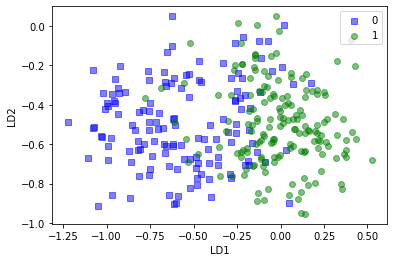

In [14]:
for label,marker,color in zip(range(0,2),('s', 'o'),('blue', 'green')):
    plt.scatter(
        x=X_lda[X_lda["target"]==label]["LDA1"],
        y=X_lda[X_lda["target"]==label]["LDA2"],
        marker=marker,
        color=color,
        alpha=0.5,
        label=label
    )
plt.xlabel('LD1')
plt.ylabel('LD2')
leg = plt.legend(loc='upper right', fancybox=True)
plt.show()

## LDA via scikit-learn

In [15]:
sklearn_lda = LDA(solver='eigen',store_covariance=True)
X_lda_sklearn = sklearn_lda.fit(X, Y)

In [16]:
X_lda_sklearn.coef_

array([[-0.3291, -1.638 ,  2.8257, -1.7638, -1.2941,  0.1452,  0.8332,
         3.3056, -1.2038, -3.0462,  1.3201, -3.3631, -2.9846]])

In [17]:
X_lda_sklearn.means_

array([[0.575 , 0.8261, 0.1594, 0.3811, 0.2856, 0.1594, 0.2246, 0.5199,
        0.5507, 0.2557, 0.5833, 0.2917, 0.8478],
       [0.4895, 0.5636, 0.4586, 0.333 , 0.2654, 0.1394, 0.297 , 0.6677,
        0.1394, 0.094 , 0.797 , 0.0909, 0.7071]])

In [18]:
X_lda_sklearn.covariance_

array([[ 3.3869e-02, -1.4218e-02,  1.8906e-03,  7.6969e-03,  4.3397e-03,
         7.7240e-03, -4.2283e-03, -1.0006e-02, -1.4717e-04,  3.9878e-03,
        -5.2783e-03,  9.0647e-03, -3.6781e-04],
       [-1.4218e-02,  1.9937e-01,  1.1587e-02, -7.4916e-03, -1.2194e-02,
         6.1467e-03, -2.3989e-03,  6.0473e-03,  4.1378e-03, -2.1663e-03,
         9.5110e-03,  9.7510e-04,  1.0749e-02],
       [ 1.8906e-03,  1.1587e-02,  9.5760e-02,  6.2676e-03, -1.6201e-03,
         1.3021e-02, -1.3622e-03,  6.7633e-03, -3.2993e-02,  2.4147e-03,
        -3.2037e-03, -9.7510e-04, -8.7448e-04],
       [ 7.6969e-03, -7.4916e-03,  6.2676e-03,  2.6712e-02,  2.1626e-03,
         1.0189e-02, -4.0850e-03,  4.1595e-04,  3.3441e-04,  4.0393e-03,
        -3.6251e-03,  1.8810e-03,  4.1563e-04],
       [ 4.3397e-03, -1.2194e-02, -1.6201e-03,  2.1626e-03,  1.3856e-02,
         4.5805e-04, -4.3212e-03,  5.3637e-04,  1.6509e-03,  3.8078e-04,
         9.2466e-04,  1.1193e-03,  1.6724e-03],
       [ 7.7240e-03,  6.1467e-

In [19]:
X_lda_sklearn.predict_proba(X)

array([[9.9056e-02, 9.0094e-01],
       [2.2027e-01, 7.7973e-01],
       [2.5946e-02, 9.7405e-01],
       [5.6293e-02, 9.4371e-01],
       [1.5766e-01, 8.4234e-01],
       [1.9123e-01, 8.0877e-01],
       [1.1921e-01, 8.8079e-01],
       [1.0970e-01, 8.9030e-01],
       [1.2712e-01, 8.7288e-01],
       [4.9171e-02, 9.5083e-01],
       [2.8933e-01, 7.1067e-01],
       [1.1173e-02, 9.8883e-01],
       [7.3520e-02, 9.2648e-01],
       [2.2120e-01, 7.7880e-01],
       [7.2759e-03, 9.9272e-01],
       [1.9214e-02, 9.8079e-01],
       [4.8699e-03, 9.9513e-01],
       [1.2095e-01, 8.7905e-01],
       [2.8614e-01, 7.1386e-01],
       [4.4955e-02, 9.5505e-01],
       [5.8015e-01, 4.1985e-01],
       [6.2749e-02, 9.3725e-01],
       [1.1273e-01, 8.8727e-01],
       [4.1206e-01, 5.8794e-01],
       [1.0951e-01, 8.9049e-01],
       [1.6727e-01, 8.3273e-01],
       [7.3472e-02, 9.2653e-01],
       [5.4554e-02, 9.4545e-01],
       [5.5841e-02, 9.4416e-01],
       [2.1646e-01, 7.8354e-01],
       [1.

## Referencias

[towardsdatascience](https://towardsdatascience.com/linear-discriminant-analysis-explained-f88be6c1e00b)

[ejemplo](https://sebastianraschka.com/Articles/2014_python_lda.html)